In [17]:
import segmentation_models as sm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K 
from skimage.io import imread, imsave, imshow
import glob
import os
import re
import itertools
import numpy as np
import matplotlib.pyplot as plt
import skimage.morphology as skmorph
import skimage.measure as skmeas
from scipy.signal import argrelextrema, find_peaks_cwt
import pandas as pd
import seaborn as sns
from ipywidgets import interact, IntSlider
from scipy import stats 
from time import process_time
import pickle

#priority to the ventricle
cls_weights=np.array([1,0.5,2])
jacc_loss=sm.losses.JaccardLoss(class_weights=cls_weights, class_indexes=None, per_image=False, smooth=1e-05)

# working with sm.model resnet18 and image as integer

dice_loss  = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [18]:
def stats_groups(df,grouping,parameter="Delta_DIA-SYS"):
    df_drug_groups=df[["Drug",parameter]].groupby(by=["Drug"])
    drug_keys=list(df_drug_groups.groups.keys())

    stat={groups: df_drug_groups.get_group(groups)[parameter].values for groups in drug_keys}

    df_stat=pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in stat.items() ]))
    alpha=0.05
    df_test=df_stat.copy()
    dict_significance=[]

    for i in df_test.columns:
        a,b =stats.kruskal(df_test["Control"],df_test[i],nan_policy="omit")
        if b < alpha:
            difference=True

        else:
            difference=False

        dict_significance.append(["Control vs. {}".format(i),b,difference])
    return dict_significance

In [15]:
def find_exports(path="E:/Data_Drug_Screening_CovidBox/Acquifer/",keyword2="20201218_drug_screen_FliV_Myl7mR_1D02_1D11_ExpID04",keyword3="_BF_550_10x",keyword4="_PlateDescription",remove_empty=True):
    
    merge=[]
    
         
    for subfolders in os.listdir(path):

        if (keyword2 in subfolders) and (os.path.isdir(os.path.join(path,subfolders))):
            list_paths=[]
            list_descriptions=[]

            for filefolders in os.listdir(os.path.join(path,subfolders)):

                if keyword3 in filefolders:
                    list_paths.append(os.path.join(path,subfolders,filefolders))

                if (keyword4 in filefolders) and ("~" not in filefolders): 
                    list_descriptions.append(os.path.join(path,subfolders,filefolders))

            merge.append([list_paths,list_descriptions])
    if remove_empty:
        res = [ele for ele in merge if ele != [[], []]]
        return res
    else:
        return merge

In [16]:
find_exports()

[[['E:/Data_Drug_Screening_CovidBox/Acquifer/20201218_drug_screen_FliV_Myl7mR_1D02_1D11_ExpID04\\20201218_FV_M7R_D02_D11_BF_550_10x'],
  ['E:/Data_Drug_Screening_CovidBox/Acquifer/20201218_drug_screen_FliV_Myl7mR_1D02_1D11_ExpID04\\20201217_drug_screen_D02_D11__PlateDescription.xlsx']]]

In [19]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])

    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)


In [20]:
def read_batches_imageseries(merged_path,well,end=100,chunks=25):
    list_images_well=glob.glob(merged_path+"-"+well+"--PO01--LO001--CO5*")[:end]
    if list_images_well==[]:
        list_images_well=glob.glob(merged_path+"-"+well+"--PO01--LO001--CO4*")[:end]
    
    
    n_images=len(list_images_well)
    if n_images != end:
        print("STOP: n_images{} != end {}".format(n_images,end))
        return
    
    n_batches=int((n_images+chunks)/chunks)
    
    image_stack=np.zeros([n_batches-1,int(chunks),512,512,1])
    count=0
    batch=0
    for i,im in enumerate(list_images_well):
        img=imread(im.replace("\\","/"))
        new_arr = np.expand_dims(((img - img.min()) * (1/(img.max() - img.min()) * 255)).astype('uint8'),axis=-1)
        
        image_stack[batch,count,:,:,:]=new_arr
        
        count+=1
        if count == (chunks): 
            count=0
            batch+=1
    yield image_stack


#changed return to yield
def batch_pred_LC(batch):
    pred=model.predict(batch)
    K.clear_session()
    return pred

def assign_compounds(value,dict_compound={}):
            n=[j for i,j in zip(dict_compound.values(),dict_compound.keys()) if value in i.values()];
            return n[0]
def apply_to_wells(merged_path,path_platemap,well_list,end=100):
    plate=merged_path.rsplit("/",3)[1]
    well_gen=itertools.chain.from_iterable(well_list)
    
    fig, axs = plt.subplots(8,12, figsize=(15, 6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)

    axs = axs.ravel()
    plt.axis('off')
    results_dict={}
    
    for k,well in enumerate(well_gen):
        K.clear_session()
        if k <96:
            try:
                image_batches=read_batches_imageseries(merged_path,well,end=end,chunks=25)           
                batch_predictions=np.reshape(np.array([batch_pred_LC(i) for i in next(image_batches)]),(end, 512, 512, 3))
            except:
                continue
            list_results=[]
            frame=[]
            check_out=0
            for i in range(batch_predictions.shape[0]):
                pred_ventricle=skmorph.remove_small_objects(batch_predictions[i,:,:,2]>0.6,min_size=50)
                                
                labels=skmorph.label(pred_ventricle)
                frame.append(i)
                props=skmeas.regionprops(labels)
                if props != []:
                    area=np.sum([label_i.area for label_i in props])
                    list_results.append(area)
                elif props == []:
                    list_results.append(np.nan)
            results_dict[well]=(frame,list_results)

            axs[k].plot(frame,list_results)
            axs[k].set_title(str(well))

    plt.show()
    well_gen=itertools.chain.from_iterable(well_list)

    results_delta_min_max=[]
    for i in well_gen:
        try:
            y = np.array(results_dict[i][1])
            x = np.array(results_dict[i][0])
            # for local maxima
        except: 
            continue
        if not np.any(np.isnan(y)): 
            #y=np.nan_to_num(y, nan=np.nanmean(y))
            local_max=y[find_peaks_cwt(y,3)]
            local_max_mean=local_max.mean()  #< np.where(local_max.mean())

            # for local minima

            local_min=y[find_peaks_cwt(1/y,3)]
            local_min_mean=local_min.mean() #< np.where(local_min.mean())
            results_delta_min_max.append(( i ,local_max,local_min,(local_max_mean-local_min_mean) / local_max_mean))
        else:
            results_delta_min_max.append(( i ,np.nan,np.nan,np.nan))
    df=pd.DataFrame(np.array([b[3] for b in results_delta_min_max]),index=np.array([i[0] for i in results_delta_min_max]),columns=["Delta_DIA-SYS"])


    df_platemap=pd.read_excel(path_platemap[0])
    dict_compoundgroup=df_platemap.to_dict()

    df=df.reset_index().rename(columns={"index":"Well"})#
    df["Drug"]=df.Well.apply(assign_compounds,dict_compound=dict_compoundgroup)

    parameter="Delta_DIA-SYS"
    df_drug_groups=df[["Drug",parameter]].groupby(by=["Drug"])
    drug_keys=list(df_drug_groups.groups.keys())

    stat={groups: df_drug_groups.get_group(groups)[parameter].values for groups in drug_keys}

    df_stat=pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in stat.items() ]))
    alpha=0.05
    df_test=df_stat.copy()
    dict_significance=[]
    display(df_test)
    for i in df_test.columns:
        try:
            a,b =stats.kruskal(df_test["Control"],df_test[i],nan_policy="omit")
            if b < alpha:
                difference=True

            else:
                difference=False
        except:
            difference=np.nan
            b=np.nan
        dict_significance.append(["Control vs. {}".format(i),b,difference])

    return plate,results_dict,df,dict_significance

In [21]:
model=keras.models.load_model("../Model/AIM_BestWeights_heart_bb_resnet18__trainSz_348__lossfun_weightedJaccLoss__lr_0.001__act_softmax__batchsz_4__pat-50__epo-250.h5",custom_objects={"jaccard_loss" : jacc_loss,"dice_loss":dice_loss})


well_gen=itertools.chain.from_iterable(well_list)

fig1, axs1 = plt.subplots(2,6, figsize=(15, 6), facecolor='w', edgecolor='k')
fig1.subplots_adjust(hspace = .5, wspace=.001)

axs1 = axs1.ravel()

for k1,well1 in enumerate(well_gen):
    if k1 < 12:
        img_series1=read_image_series(merged_path,well1)
        val_preds1 = model.predict(img_series1[:2])
        fig1.add_subplot(2, 6, k1+1)
        plt.imshow(skmorph.remove_small_objects(val_preds1[1,:,:,2]>0.6,min_size=350))
        
        

In [22]:
merged_path= 'E:/Data_Drug_Screening_CovidBox/Acquifer/20210326_drug_screen_FliV_Myl7mR_1A02_1A11_ExpID01/20210326_FV_M7R_1A02_1A11_BF_550_10x/'
well='A002'
end=100
#list_images_well=glob.glob(merged_path+"-"+well+"--PO01--LO001--CO5*")[:end]
#list_images_well
image_batches=read_batches_imageseries(merged_path,well,chunks=25)           
batch_predictions=np.reshape(np.array([batch_pred_LC(i) for i in next(image_batches)]),(end, 512, 512, 3))

In [28]:
image_batches=read_batches_imageseries(merged_path,well,chunks=25) 

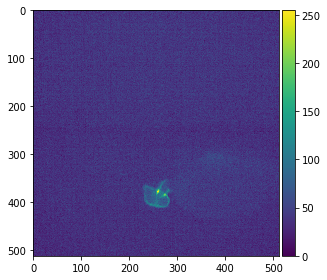

In [29]:
imshow(next(image_batches)[0][0])

C:\Users\aernst\Miniconda3\envs\TF25\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


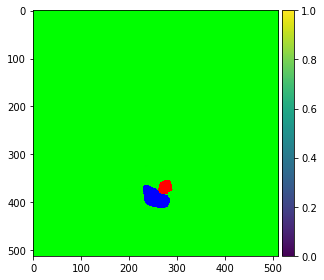

In [23]:
imshow(batch_predictions[0])

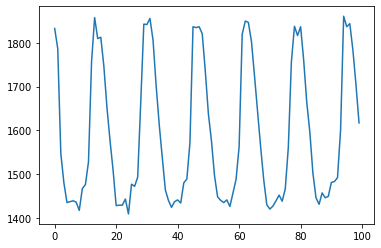

In [30]:
results_dict={}
list_results=[]
frame=[]
check_out=0
for i in range(batch_predictions.shape[0]):
    pred_ventricle=skmorph.remove_small_objects(batch_predictions[i,:,:,2]>0.6,min_size=50)

    labels=skmorph.label(pred_ventricle)
    frame.append(i)
    props=skmeas.regionprops(labels)
    if props != []:
        area=np.sum([label_i.area for label_i in props])
        list_results.append(area)
    elif props == []:
        list_results.append(np.nan)
results_dict[well]=(frame,list_results)

plt.plot(frame,list_results)
plt.savefig("E:/Data_Drug_Screening_CovidBox/Paper_Draft/Figures/Figure3_Image Analysis/images/ventricle_plot.pdf")
#plt.set_title(str(well))

In [34]:
def run_for_all():
    
    list_rows=["A","B"]
    list_cols=[",","001,","002,","003,","004,","005,","006,","007,","008,","009,","010,","011,","012,"]
    well_list=[i.join(list_cols)[1:-1].split(",") for i in list_rows]
    
    images=find_exports()
    
    for maxprojfolder,description in images:
        if maxprojfolder != []:
            name=maxprojfolder[0].rsplit("\\",1)[0]
            name_out=maxprojfolder[0].rsplit("\\",1)[1]
            print(description)
            print(maxprojfolder)
            print(name_out)
            image_folder=maxprojfolder[0].replace("\\","/")+"/"
            
            plate,results_dict,df_results_delta_min_max,dict_significance = apply_to_wells(image_folder,description,well_list)
            
            collection=(plate,results_dict,df_results_delta_min_max,dict_significance)
            
            save_pickle_path=os.path.join(name,"Measurements_new2")
            
            if not os.path.exists(save_pickle_path):
                os.mkdir(save_pickle_path) 
              
            open_file = open(save_pickle_path+"/"+ plate, "wb")
            pickle.dump(collection, open_file)
            open_file.close()
            collection=[]
            
            sns.swarmplot(x="Drug",y="Delta_DIA-SYS",data=df_results_delta_min_max)
            sns.boxplot(x="Drug",y="Delta_DIA-SYS",data=df_results_delta_min_max,color="white")
            plt.xticks(
                rotation=45, 
                horizontalalignment='right',
                fontweight='light',
                fontsize='x-large'  
            );
            #df_results_delta_min_max.to_csv(os.path.join(save_pickle_path,"Table_HeartUnetAnalysis_"+name_out+".csv"))
            print(dict_significance)
            #dict_significance.to_csv(os.path.join(save_pickle_path,"_Significance_HeartUnetAnalysis_"+name_out+".csv"))   
            #plt.savefig(os.path.join(save_pickle_path,"UnetAnalysis_"+name_out+".png"))
            plt.show()
            
            #df.to_pickle(os.path.join(save_pickle_path,"UnetAnalysis_"+name_out+".pkl"))
            df=[]
        

['E:/Data_Drug_Screening_CovidBox/Acquifer/20201218_drug_screen_FliV_Myl7mR_1D02_1D11_ExpID04\\20201217_drug_screen_D02_D11__PlateDescription.xlsx']
['E:/Data_Drug_Screening_CovidBox/Acquifer/20201218_drug_screen_FliV_Myl7mR_1D02_1D11_ExpID04\\20201218_FV_M7R_D02_D11_BF_550_10x']
20201218_FV_M7R_D02_D11_BF_550_10x


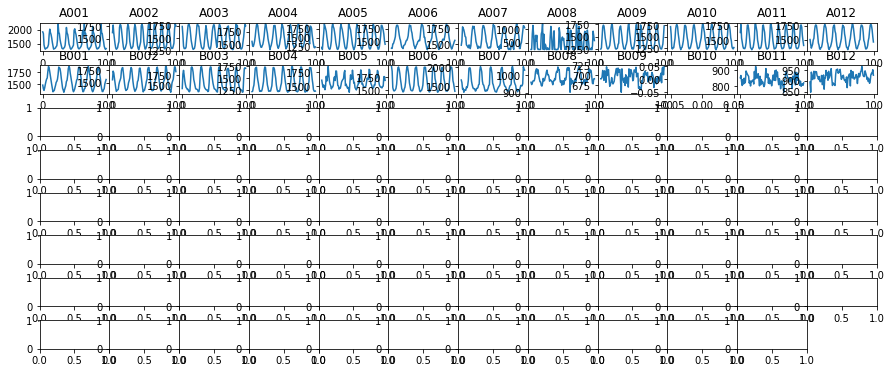

,Amodiaquine_1D03,Astemizole_1D04,Digoxin_1D02
0,0.254340,0.052721,0.275543
1,0.178309,0.016242,0.231725
2,0.191500,NaN,0.216458
3,0.210428,0.048894,0.181303
4,0.195451,0.021333,0.312644
5,0.236728,NaN,0.193725
6,0.263477,NaN,0.144276
7,0.141741,NaN,0.522723
8,0.196180,NaN,0.236231
9,0.258495,NaN,NaN


[['Control vs. Amodiaquine_1D03', nan, nan], ['Control vs. Astemizole_1D04', nan, nan], ['Control vs. Digoxin_1D02', nan, nan]]


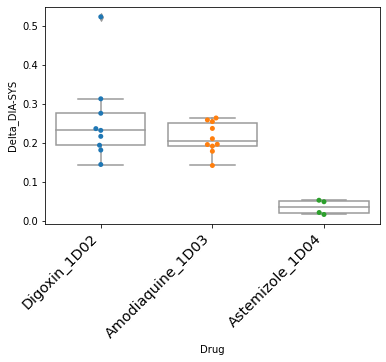

In [35]:
run_for_all()

In [9]:
merged_path="E:/Data_Drug_Screening_CovidBox/Acquifer/20210204_5th_session/20210204_drug_screen_FliV_Myl7mR_F02_F11/"


In [10]:
df_2b=pd.read_csv("E:/Data_Drug_Screening_CovidBox/Acquifer/20210204_5th_session/20210204_drug_screen_FliV_Myl7mR_F02_F11/Measurements/Table_HeartUnetAnalysis_20200204_FV_M7R_F02_F11_BF_550_10x.csv")
df_2b

array(['ABT 239_1F10', 'Amiodarone_1F03', 'Captopril_1F07', 'Control',
       'Cyclosporine_1F04', 'Hydroxychloroquine_1F11',
       'Indomethacin_1F06', 'Ivermectin_1F05', 'Ribavirin_1F08',
       'Sorafenib_1F09', 'Valsartan_1F02'], dtype=object)

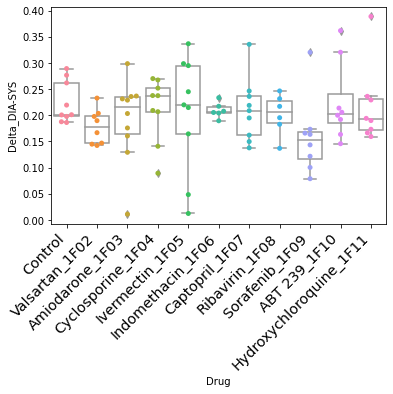

In [98]:
drugOrder=['Control','Valsartan_1F02','Amiodarone_1F03','Cyclosporine_1F04','Ivermectin_1F05','Indomethacin_1F06','Captopril_1F07','Ribavirin_1F08',
       'Sorafenib_1F09', 'ABT 239_1F10', 'Hydroxychloroquine_1F11']
sns.boxplot(x="Drug",y="Delta_DIA-SYS",data=df_2b,order=drugOrder,color="white")
sns.swarmplot(x="Drug",y="Delta_DIA-SYS",data=df_2b,order=drugOrder)
plt.xticks(
                rotation=45, 
                horizontalalignment='right',
                fontweight='light',
                fontsize='x-large'  
            );

In [94]:
df_2b.head(10)

,Unnamed: 0,Well,Delta_DIA-SYS,Drug
0,0,A001,0.232903,Valsartan_1F02
1,1,A002,0.189804,Valsartan_1F02
2,2,A003,0.203738,Valsartan_1F02
3,3,A004,0.197865,Valsartan_1F02
4,4,A005,0.144897,Valsartan_1F02
5,5,A006,0.146943,Valsartan_1F02
6,6,A007,0.166823,Valsartan_1F02
7,7,A008,0.142391,Valsartan_1F02
8,8,A009,0.298731,Amiodarone_1F03
9,9,A010,0.231419,Amiodarone_1F03


In [12]:
stats_groups(df_2b,"Drug",parameter="Delta_DIA-SYS")

[['Control vs. ABT 239_1F10', 0.7728299926844444, False],
 ['Control vs. Amiodarone_1F03', 0.567628499263335, False],
 ['Control vs. Captopril_1F07', 0.5078006482752742, False],
 ['Control vs. Control', 1.0, False],
 ['Control vs. Cyclosporine_1F04', 0.8946258095467479, False],
 ['Control vs. Hydroxychloroquine_1F11', 0.289838717607506, False],
 ['Control vs. Indomethacin_1F06', 0.9061856157549151, False],
 ['Control vs. Ivermectin_1F05', 0.7572777496236265, False],
 ['Control vs. Ribavirin_1F08', 0.3457785861511592, False],
 ['Control vs. Sorafenib_1F09', 0.0093747684594349, True],
 ['Control vs. Valsartan_1F02', 0.04330814281079203, True]]

(4, 25, 512, 512, 1)

In [8]:
def save_movie(well,images,segmentations,path_out_im,path_out_seg):
    if not os.path.exists(path_out_im) or not os.path.exists(path_out_seg):
        os.mkdir(path_out_im)
        os.mkdir(path_out_seg)
        
    for i,(im,seg) in enumerate(zip(images,segmentations)):
        imsave(os.path.join(path_out_im,well+"_"+str(i)+".tif"),im)
        imsave(os.path.join(path_out_seg,well+"_"+str(i)+".tif"),seg)
        
def plot_plane(t):
    plt.figure(figsize=(20,10))
    plt.subplot(131)
    plt.imshow(image_series[t,:,:,:])
    plt.subplot(132)
    plt.imshow(batch_predictions[t,:,:,2]>0.6)
    plt.subplot(133)
    plt.imshow(skmorph.convex_hull_image(batch_predictions[t,:,:,2]>0.6))
    plt.show()

In [24]:
merged_path="E:/Data_Drug_Screening_CovidBox/Acquifer/20210903_drug_screen_FliV_Myl7R_ScreenSelectedP2/20210903_FV_M7R_SSP2_BF_550_10x/"
well="H004"
image_batches2=read_batches_imageseries(merged_path,well,end=100,chunks=25)
image_batches=read_batches_imageseries(merged_path,well,end=100,chunks=25)           
batch_predictions=np.reshape(np.array([batch_pred_LC(i) for i in next(image_batches)]),(100, 512, 512, 3))


image_series=np.array([i for i in image_batches2])
image_series=np.reshape(image_series[0],(100, 512, 512, 1))

In [23]:
path_out_im= "E:/Data_Drug_Screening_CovidBox/Paper_Draft/Figures/Figure4_Acq Example Results/images/heart"
path_out_seg= "E:/Data_Drug_Screening_CovidBox/Paper_Draft/Figures/Figure4_Acq Example Results/images/heartseg"

save_movie("H007",image_series,batch_predictions,path_out_im,path_out_seg)

C:\Users\aernst\AppData\Local\Temp/ipykernel_7076/1026304949.py:8: UserWarning: E:/Data_Drug_Screening_CovidBox/Paper_Draft/Figures/Figure4_Acq Example Results/images/heartseg\H007_0.tif is a low contrast image
  imsave(os.path.join(path_out_seg,well+"_"+str(i)+".tif"),seg)
C:\Users\aernst\AppData\Local\Temp/ipykernel_7076/1026304949.py:8: UserWarning: E:/Data_Drug_Screening_CovidBox/Paper_Draft/Figures/Figure4_Acq Example Results/images/heartseg\H007_1.tif is a low contrast image
  imsave(os.path.join(path_out_seg,well+"_"+str(i)+".tif"),seg)
C:\Users\aernst\AppData\Local\Temp/ipykernel_7076/1026304949.py:8: UserWarning: E:/Data_Drug_Screening_CovidBox/Paper_Draft/Figures/Figure4_Acq Example Results/images/heartseg\H007_2.tif is a low contrast image
  imsave(os.path.join(path_out_seg,well+"_"+str(i)+".tif"),seg)
C:\Users\aernst\AppData\Local\Temp/ipykernel_7076/1026304949.py:8: UserWarning: E:/Data_Drug_Screening_CovidBox/Paper_Draft/Figures/Figure4_Acq Example Results/images/heartseg

In [25]:
interact(plot_plane, t = IntSlider(min=0,max=100,step=1,value=0,continuous_update = True));

interactive(children=(IntSlider(value=0, description='t'), Output()), _dom_classes=('widget-interact',))

In [97]:
well_out="A007"
if not os.path.exists("C:/Users/aernst/Desktop/{}/".format(well_out)):
    os.mkdir("C:/Users/aernst/Desktop/{}/".format(well_out))
path_out_im="C:/Users/aernst/Desktop/{}/Images/".format(well_out)
path_out_seg="C:/Users/aernst/Desktop/{}/Segmentations/".format(well_out)
save_movie(well_out,image_series,batch_predictions,path_out_im,path_out_seg)

C:\Users\aernst\AppData\Local\Temp/ipykernel_27800/1026304949.py:8: UserWarning: C:/Users/aernst/Desktop/A007/Segmentations/A007_6.tif is a low contrast image
  imsave(os.path.join(path_out_seg,well+"_"+str(i)+".tif"),seg)
C:\Users\aernst\AppData\Local\Temp/ipykernel_27800/1026304949.py:8: UserWarning: C:/Users/aernst/Desktop/A007/Segmentations/A007_8.tif is a low contrast image
  imsave(os.path.join(path_out_seg,well+"_"+str(i)+".tif"),seg)
C:\Users\aernst\AppData\Local\Temp/ipykernel_27800/1026304949.py:8: UserWarning: C:/Users/aernst/Desktop/A007/Segmentations/A007_16.tif is a low contrast image
  imsave(os.path.join(path_out_seg,well+"_"+str(i)+".tif"),seg)
C:\Users\aernst\AppData\Local\Temp/ipykernel_27800/1026304949.py:8: UserWarning: C:/Users/aernst/Desktop/A007/Segmentations/A007_22.tif is a low contrast image
  imsave(os.path.join(path_out_seg,well+"_"+str(i)+".tif"),seg)
C:\Users\aernst\AppData\Local\Temp/ipykernel_27800/1026304949.py:8: UserWarning: C:/Users/aernst/Desktop/A

<BarContainer object of 96 artists>

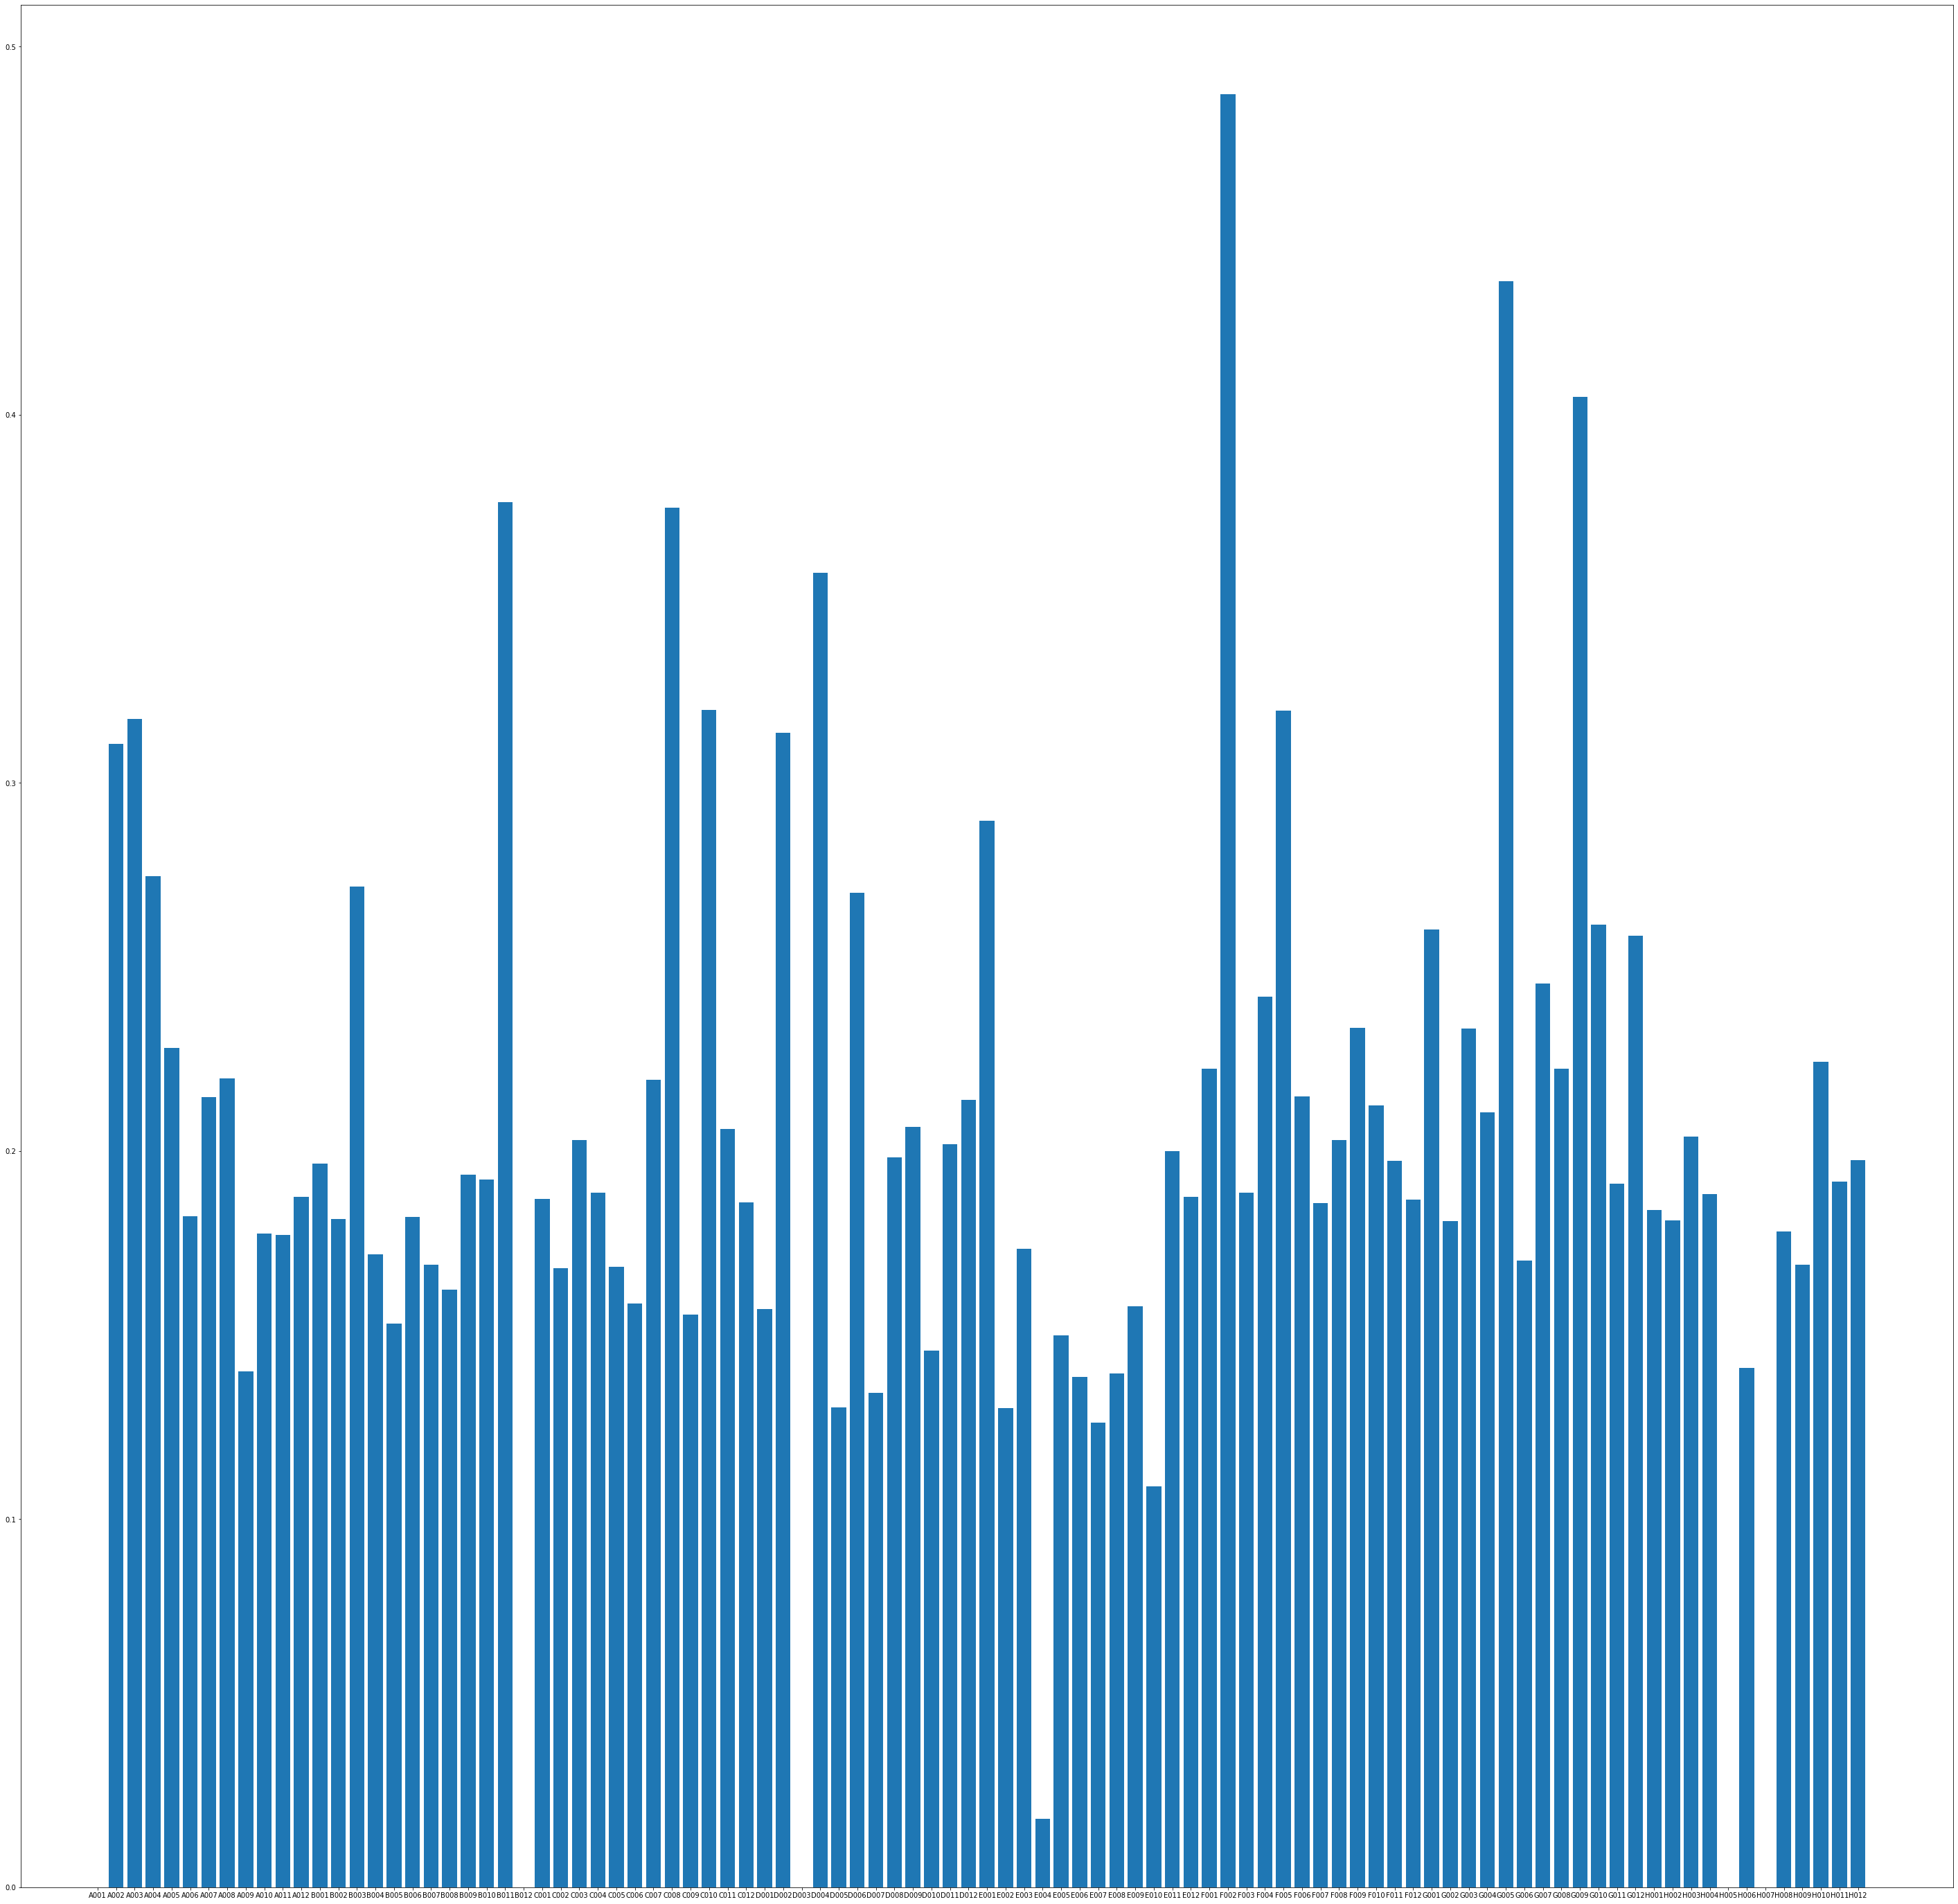

In [17]:
plt.figure(figsize=(50,50))
plt.bar([i[0] for i in results_delta_min_max],[b[3] for b in results_delta_min_max])

In [26]:
df=pd.DataFrame(np.array([b[3] for b in results_delta_min_max]),index=np.array([i[0] for i in results_delta_min_max]),columns=["Delta_DIA-SYS"])
def assign_compounds(value,dict_compound={}):
    n=[j for i,j in zip(dict_compound.values(),dict_compound.keys()) if value in i.values()];
    return n[0]
    
df_platemap=pd.read_excel("E:/Data_Drug_Screening_CovidBox/Acquifer/20210325_8th_session/20210326_drug_screen_FliV_Myl7R_1A02_1A11/20210225_drug_screen_1A02_1A11_rep2__PlateDescription.xlsx")
dict_compoundgroup=df_platemap.to_dict()

df=df.reset_index().rename(columns={"index":"Well"}).dropna()#
df["Drug"]=df.Well.apply(assign_compounds,dict_compound=dict_compoundgroup)

In [19]:
df.to_csv("./Ejection_fraction_1Arep.csv")

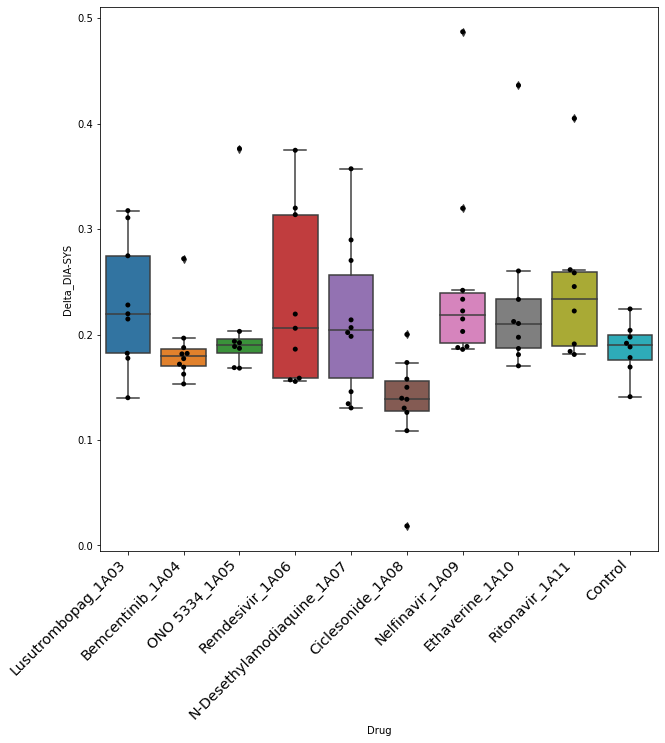

In [27]:

plt.figure(figsize=(10,10))

ax=sns.boxplot(x="Drug",y="Delta_DIA-SYS", data=df)
ax=sns.swarmplot(x="Drug",y="Delta_DIA-SYS",data=df,color="black")


plt.xticks(
                rotation=45, 
                horizontalalignment='right',
                fontweight='light',
                fontsize='x-large'  
            );
plt.show()

In [34]:
df

,Well,Delta_DIA-SYS,Drug
1,A002,0.310692,Lusutrombopag_1A03
2,A003,0.317463,Lusutrombopag_1A03
3,A004,0.274656,Lusutrombopag_1A03
4,A005,0.227987,Lusutrombopag_1A03
5,A006,0.182207,Lusutrombopag_1A03
...,...,...,...
91,H008,0.178148,Control
92,H009,0.169161,Control
93,H010,0.224262,Control
94,H011,0.191716,Control


In [44]:
df_test

,Bemcentinib_1A04,Ciclesonide_1A08,Control,Ethaverine_1A10,Lusutrombopag_1A03,N-Desethylamodiaquine_1A07,Nelfinavir_1A09,ONO 5334_1A05,Remdesivir_1A06,Ritonavir_1A11
0,0.177145,0.130216,0.203978,0.212328,0.310692,0.357139,0.187640,0.193548,0.158608,0.245472
1,0.187586,0.173434,0.188235,0.197402,0.317463,0.130404,0.222359,0.192266,0.219407,0.222306
2,0.196576,0.018496,0.141045,0.186749,0.274656,0.270229,0.487055,0.376296,0.374706,0.404930
3,0.181618,0.149939,0.178148,0.260258,0.227987,0.134381,0.188663,0.186905,0.155521,0.261455
4,0.271940,0.138573,0.169161,0.180931,0.182207,0.198271,0.241919,0.168120,0.319873,0.191063
5,0.171904,0.126139,0.224262,0.233327,0.214696,0.206585,0.319658,0.202965,0.205943,0.258471
6,0.153139,0.139593,0.191716,0.210437,0.219641,0.145794,0.214770,0.188625,0.186136,0.183997
7,0.182052,0.157754,0.197556,0.436295,0.140059,0.201874,0.185922,0.168594,0.156999,0.181084
8,0.169021,0.108829,NaN,0.170280,0.177502,0.213887,0.202916,NaN,0.313643,NaN
9,0.162404,0.200048,NaN,NaN,NaN,0.289656,0.233454,NaN,NaN,NaN


In [45]:
dict_significance

[['Control vs. Bemcentinib_1A04', 0.3283832142406826, False],
 ['Control vs. Ciclesonide_1A08', 0.007685794055213253, True],
 ['Control vs. Control', 1.0, False],
 ['Control vs. Ethaverine_1A10', 0.14891467317876134, False],
 ['Control vs. Lusutrombopag_1A03', 0.14891467317876134, False],
 ['Control vs. N-Desethylamodiaquine_1A07', 0.3283832142406826, False],
 ['Control vs. Nelfinavir_1A09', 0.05061243223918493, False],
 ['Control vs. ONO 5334_1A05', 0.9163591402734728, False],
 ['Control vs. Remdesivir_1A06', 0.4414183267820554, False],
 ['Control vs. Ritonavir_1A11', 0.07420341132975534, False]]

In [ ]:

for i in range(96):

    axs[i].contourf(np.random.rand(10,10),5,cmap=plt.cm.Oranges)
    axs[i].set_title(str(250+i))

In [19]:
val_preds = model.predict(img_series)

In [41]:
list_results=[]
frame=[]
for i in range(100):
    pred_ventricle=skmorph.binary_closing(skmorph.remove_small_objects(val_preds[i,:,:,2]>0.6,min_size=220))
    labels=skmorph.label(pred_ventricle)
    frame.append(i)
    list_results.append(skmeas.regionprops(labels)[0].area)
print(list(enumerate(list_results)))
plt.plot(frame,list_results)

IndexError: list index out of range

AttributeError: module 'skimage.morphology' has no attribute 'val_preds'

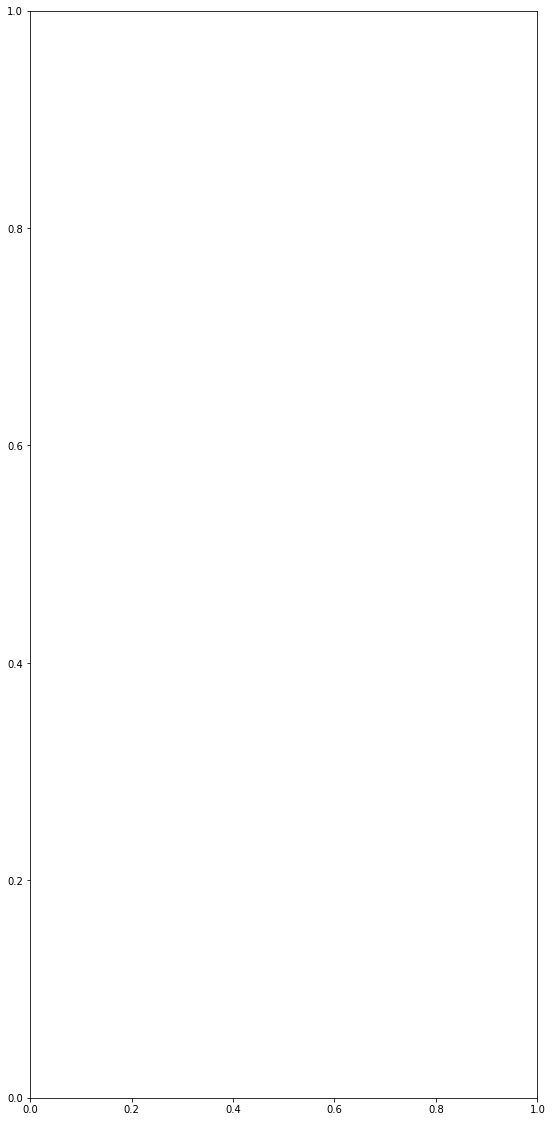

In [21]:
plt.figure(figsize=(20,20))

n=10
plt.subplot(121)
imshow(skmorph.val_preds[n,:,:,1]>0.6)
plt.subplot(122)
imshow(img_series[n,:,:,0])
plt.show()